In [1]:
import warnings
warnings.filterwarnings("ignore")
from PIL import Image
import shutil
import os
import pandas as pd
import imageio
import array
import matplotlib
matplotlib.use(u'nbAgg')
from tqdm import tqdm
import matplotlib.pyplot as plt
from itertools import permutations
from itertools import product
import seaborn as sns
import numpy as np
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

C:\Users\User\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [ ]:
Followed the following steps in order to create a trained model that can identify virus infected folders into 9 different classes 

Step1:  

Preparing data: Download the data from https://www.kaggle.com/c/malware-classification 

The data downloaded will be in a .7z file, after extracting we will end up with two folders  

1.byteFiles 

2.asmFiles 

In [ ]:
#separating byte files and asm files 
source = 'train'
destination_1 = 'byteFiles'
destination_2 = 'asmFiles'

# we will check if the folder 'byteFiles' exists if it not there we will create a folder with the same name
if not os.path.isdir(destination_1):
    os.makedirs(destination_1)
if not os.path.isdir(destination_2):
    os.makedirs(destination_2)

# if we have folder called 'train' (train folder contains both .asm files and .bytes files) we will rename it 'asmFiles'
# for every file that we have in our 'asmFiles' directory we check if it is ending with .bytes, if yes we will move it to
# 'byteFiles' folder

# so by the end of this snippet we will separate all the .byte files and .asm files
if os.path.isdir(source):
    data_files = os.listdir(source)
    for file in data_files:
        print(file)
        if (file.endswith("bytes")):
            shutil.move(source+'\\'+file,destination_1)
        if (file.endswith("asm")):
            shutil.move(source+'\\'+file,destination_2)

In [ ]:
Univariate Analysis:
    Here we need to find wether the data is equally distributed or not

<IPython.core.display.Javascript object>


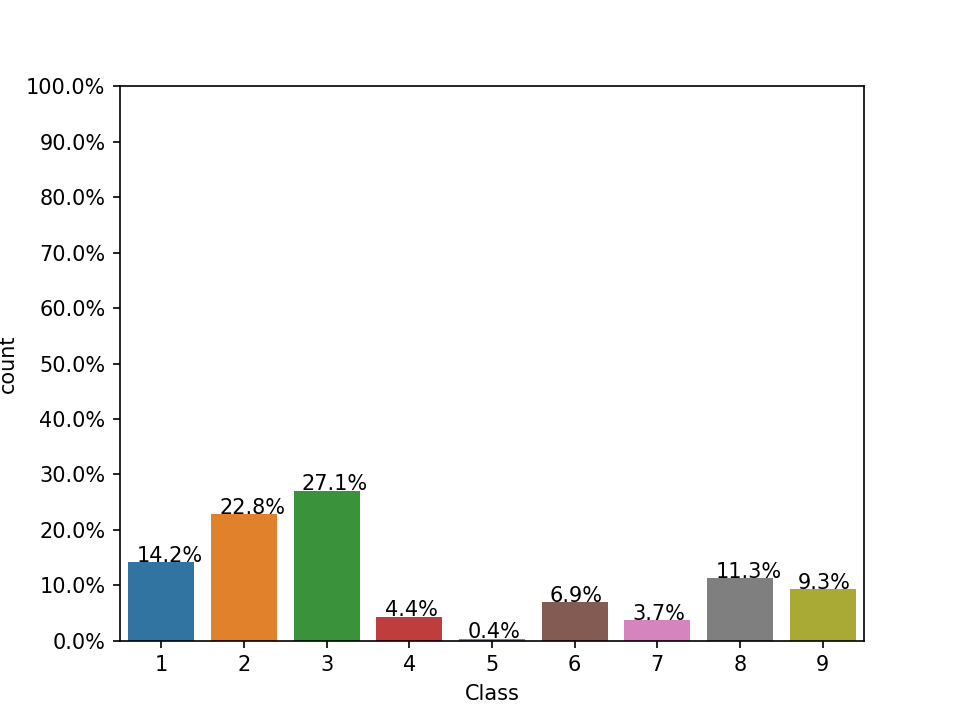

In [6]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [ ]:
Let us validate wether the size of each datapoint plays a role in clas distribution or not

In [7]:
#Sorting classes based on size of their respective file sizes
#file sizes of byte files
files=os.listdir('C://Users//User//Desktop//Applied AI//Ms malware detection//train//byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    # print(os.stat('byteFiles/0A32eTdBKayjCWhZqDOQ.txt'))
    # os.stat_result(st_mode=33206, st_ino=1125899906874507, st_dev=3561571700, st_nlink=1, st_uid=0, st_gid=0, 
    # st_size=3680109, st_atime=1519638522, st_mtime=1519638522, st_ctime=1519638522)
    # read more about os.stat: here https://www.tutorialspoint.com/python/os_stat.htm
    statinfo=os.stat('C://Users//User//Desktop//Applied AI//Ms malware detection//train//byteFiles/'+file)
    # split the file name at '.' and take the first part of it i.e the file name
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        # converting into Mb's
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  4.234863      9
1  01IsoiSMh5gxyDYTl4CB  5.538818      2
2  01jsnpXSAlgw6aPeDxrU  3.887939      9
3  01kcPWA9K2BOxQeS5Rju  0.574219      1
4  01SuzwMJEIXsK7A8dQbl  0.370850      8


In [ ]:
Creating bigrams using byteFiles.  

Unfortunately, directly using CountVectorizer from sklearn will not be useful in this scenario as it can take high processing
time, we created a customized function to count bigrams. 

First, we created a list bi_grams_str which contains all the possible bigrams of 00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,
10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,
3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,
66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,
91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,
bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,
e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff 


In [ ]:
#Finding all the bigrams in the given dataset
byte_details = [str(i) for i in '00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,
                20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45
                ,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,
                6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90
                ,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,
                b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,
                db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff'
                .split(',')]

bi_grams = product(byte_details,repeat = 2)
#Converting to iettools class to list
bi_grams_str = [i+ ' ' +j for (i,j) in bi_grams]

In [ ]:
bi_grams_str is a list containing all the possible bigrams

In [ ]:
#Since we have '??' impace of missing items in the given dataset
bi_grams_str.append('??')
files = os.listdir('C://Users//User//Desktop//Applied AI//Ms malware detection//train//byteFiles')
features = {i:0 for i in  files}
#To store the counts of individual bigrams we created feature_matrix_dum
feature_matrix_dum = np.zeros((len(files),len(bi_grams_str)),dtype = int)
feature_mat_dic = {j:i for i,j in enumerate(bi_grams_str)}

In [ ]:
Now we need to count all the possible bigrams and stored in the location
'C://Users//User//Desktop//Applied AI//Ms malware detection//result_bigram'

Here we ran a simple for loop on each file to count the bigrams as follows and stored it in above location

In [ ]:
def firstprocessBytes():
    byte_feature_file=open('C://Users//User//Desktop//Applied AI//Ms malware detection//result_bigram2','w+')
    k=0
    byte_feature_file.write('ID,'+','.join(bi_grams_str))
    byte_feature_file.write("\n")
    filenames2 = []
    files = os.listdir('C://Users//User//Desktop//Applied AI//Ms malware detection//train//byteFiles')
    files = [j for i,j in enumerate(files) if i >3901]
    for file in tqdm(files):
        filenames2.append(file)
        byte_feature_file.write(file+",")
        if(file.endswith("txt")):
            with open('C://Users//User//Desktop//Applied AI//Ms malware detection//train//byteFiles/'+file,"r") as byte_flie:
                feature_dic = {i:0 for i in bi_grams_str}
                for lines in (byte_flie):
                    lines = lines.replace('\n','').lower()
                    if '??' in lines:
                        feature_matrix_dum[k][feature_mat_dic['??']] += lines.count('??')
                    else:
                        l = lines.split(" ")
                        le = len(l) - 1
                        for i,word in enumerate(l):
                            if i < le:
                                feature_matrix_dum[k][feature_mat_dic[word +' ' + l[i + 1]]]+= 1

                byte_flie.close()
        
        for i, row in enumerate(feature_matrix_dum[k]):
            #print(row)
            if i!=len(feature_matrix_dum[k])-1:
                byte_feature_file.write(str(row)+",")
            else:
                byte_feature_file.write(str(row))
        byte_feature_file.write("\n")

        k += 1
        #print('k : {}'.format(k) )
    byte_feature_file.close()
firstprocessBytes()

In [ ]:
Now we have counted the bigrams

In [ ]:
As we observed that data size can play a significant role in differentiating their respective classes let us append size to 
bigram data

In [26]:
#byte_features['ID']  = byte_features['ID'].str.split('.').str[0]
print(data_size_byte.head(2))
print(result.head(2))
byte_features_with_size = result.merge(data_size_byte, on='ID')

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  4.234863      9
1  01IsoiSMh5gxyDYTl4CB  5.538818      2
                         ID   00 00  00 01  00 02  00 03  00 04  00 05  00 06  \
0  01azqd4InC7m9JpocGv5.txt  546082   2004   1602   2340   1886   1680   2250   
1  01IsoiSMh5gxyDYTl4CB.txt       8     12     18     20     22     22     16   

   00 07  00 08 ...  ff f7  ff f8  ff f9  ff fa  ff fb  ff fc  ff fd  ff fe  \
0   2006   1720 ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   
1     14     10 ...    NaN    NaN    NaN    NaN    NaN    NaN    NaN    NaN   

   ff ff  ??  
0    NaN NaN  
1    NaN NaN  

[2 rows x 65538 columns]


In [25]:
byte_features_with_size.head()

,ID,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,ff f9,ff fa,ff fb,ff fc,ff fd,ff fe,ff ff,??,size,Class


In [ ]:
Inorder to avoid confusion we normalized the given data by using the following function

In [11]:
def normalize(df):
    result1 = df.copy()
    for feature_name in tqdm(df.columns):
        #print(feature_name)
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            #If all the items in a column are equal it will result in NaN so this condition
            if max_value == min_value:
                result1[feature_name] = 1
            else:
                result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1
result = normalize(byte_features_with_size)

100%|███████████████████████████████████████████████████████████████████████████| 65540/65540 [06:40<00:00, 163.55it/s]


In [19]:
result.shape

(10867, 65538)

In [17]:
#Splitting data:
result = pd.read_csv('C://Users//User//Desktop//result_bigramFinal')
# data_y =result['Class'] 
# # split the data into test and train by maintaining same distribution of output varaible 'y_true' [stratify=y_true]
# X_train, X_test, y_train, y_test = train_test_split(result.drop(['ID','Class'], axis=1), data_y,stratify=data_y,test_size=0.20)
# # split the train data into train and cross validation by maintaining same distribution of output varaible 'y_train' [stratify=y_train]
# X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train,stratify=y_train,test_size=0.20)

KeyboardInterrupt: 

In [ ]:
In-order to avoid curse of dimentionality (since this dataset has 6k+ features) let us first run XGBoost classifier and eleiminate
the leat important featurs

In [ ]:
# Training a hyper-parameter tuned Xg-Boost regressor on our train data

# find more about XGBClassifier function here http://xgboost.readthedocs.io/en/latest/python/python_api.html?#xgboost.XGBClassifier
# -------------------------
# default paramters
# class xgboost.XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, silent=True, 
# objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, 
# max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, reg_alpha=0, reg_lambda=1, 
# scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)

# some of methods of RandomForestRegressor()
# fit(X, y, sample_weight=None, eval_set=None, eval_metric=None, early_stopping_rounds=None, verbose=True, xgb_model=None)
# get_params([deep])	Get parameters for this estimator.
# predict(data, output_margin=False, ntree_limit=0) : Predict with data. NOTE: This function is not thread safe.
# get_score(importance_type='weight') -> get the feature importance
# -----------------------
# video link2: https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/what-are-ensembles/
# -----------------------
n_estimators = list(range(100,1100,100))
learning_rate = [0.5,0.15,0.25,0.35,0.45]
best_n = 0
best_rate = 0
loss = sys.maxsize
for n in tqdm(n_estimators):
    for r in tqdm(learning_rate):
        x_cfl=XGBClassifier(n_estimators=n,subsample=0.5,learning_rate=r,colsample_bytree=0.5,max_depth=3)
        x_cfl.fit(X_train,y_train)
        c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
        c_cfl.fit(X_train,y_train)

        predict_y = c_cfl.predict_proba(X_train)
        print ('train loss',log_loss(y_train, predict_y))
        predict_y = c_cfl.predict_proba(X_cv)
        print ('cv loss',log_loss(y_cv, predict_y))
        predict_y = c_cfl.predict_proba(y_test)
        print ('test loss',log_loss(y_test, predict_y))
        if log_loss(y_test, predict_y) < loss:
            best_n = n
            best_rate = r
            loss = log_loss(y_test, predict_y)
            

x_cfl=XGBClassifier(n_estimators=best_n,subsample=0.5,learning_rate=best_rate,colsample_bytree=0.5,max_depth=3)
x_cfl.fit(X_train_asm,y_train_asm)
c_cfl=CalibratedClassifierCV(x_cfl,method='sigmoid')
c_cfl.fit(X_train_asm,y_train_asm)

predict_y = c_cfl.predict_proba(X_train_asm)
print ('train loss',log_loss(y_train_asm, predict_y))
predict_y = c_cfl.predict_proba(X_cv_asm)
print ('cv loss',log_loss(y_cv_asm, predict_y))
predict_y = c_cfl.predict_proba(X_test_asm)
print ('test loss',log_loss(y_test_asm, predict_y))       